In [30]:
import pandas as pd
import numpy as np
import re

# ----------------------------
# 1. Load file
# ----------------------------
file = "/Users/prad7599/Documents/TesterCodes/Pragya.xlsx"
df = pd.read_excel(file)

# ----------------------------
# 2. Parse Folder_Name for LAB + ΔE
# ----------------------------
pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"
def parse_name(name):
    m = re.search(pat, str(name))
    if m:
        return pd.Series([float(m.group(1)),
                          float(m.group(2)),
                          float(m.group(3)),
                          float(m.group(4))])
    return pd.Series([np.nan]*4)

df[["L","a","b","dE"]] = df.iloc[:,0].apply(parse_name)
df["Acceptable"] = df.iloc[:,2].astype(str).str.strip().str.title().replace({"Nan":"No"})
df = df.dropna(subset=["L","a","b","dE"])

# ----------------------------
# 3. Group by fixing two channels, varying one
# ----------------------------
def group_varying(df, vary="L"):
    """
    Returns a list of DataFrames where 'vary' channel changes,
    and the other two channels are fixed.
    """
    channels = ["L","a","b"]
    fixed = [c for c in channels if c != vary]
    
    # Round fixed channels to avoid floating point issues
    df["_fix1"] = df[fixed[0]].round(2)
    df["_fix2"] = df[fixed[1]].round(2)
    
    # Group by fixed channels
    grouped = df.groupby(["_fix1","_fix2"])
    
    # Create list of DataFrames
    varying_list = [g.sort_values(by=vary) for _, g in grouped]
    
    # Clean temporary columns
    for g in varying_list:
        g.drop(columns=["_fix1","_fix2"], inplace=True)
    
    return varying_list

# ----------------------------
# 4. Create lists for each varying channel
# ----------------------------
L_varying_list = group_varying(df, vary="L")
a_varying_list = group_varying(df, vary="a")
b_varying_list = group_varying(df, vary="b")

# ----------------------------
# 5. Summary: How many groups found
# ----------------------------
print(f"ΔL varying groups: {len(L_varying_list)}")
print(f"Δa varying groups: {len(a_varying_list)}")
print(f"Δb varying groups: {len(b_varying_list)}")

# Optional: inspect first group where L varies
print("\nExample group (ΔL varying, Δa & Δb fixed):")
print(L_varying_list[0][["Folder_Name","L","a","b","dE","Acceptable"]])


ΔL varying groups: 49
Δa varying groups: 49
Δb varying groups: 49

Example group (ΔL varying, Δa & Δb fixed):
                                    Folder_Name      L      a      b     dE  \
62    Face_shift_L-3.98_a-12.79_b-12.79_dE18.41  -3.98 -12.79 -12.79  18.41   
265   Face_shift_L-3.98_a-12.79_b-12.79_dE18.41  -3.98 -12.79 -12.79  18.41   
146   Face_shift_L-2.36_a-12.79_b-12.79_dE18.20  -2.36 -12.79 -12.79  18.20   
139   Face_shift_L+3.22_a-12.79_b-12.79_dE18.37   3.22 -12.79 -12.79  18.37   
342   Face_shift_L+3.22_a-12.79_b-12.79_dE18.37   3.22 -12.79 -12.79  18.37   
63    Face_shift_L+5.77_a-12.79_b-12.79_dE18.98   5.77 -12.79 -12.79  18.98   
266   Face_shift_L+5.77_a-12.79_b-12.79_dE18.98   5.77 -12.79 -12.79  18.98   
25   Face_shift_L+16.03_a-12.79_b-12.79_dE24.16  16.03 -12.79 -12.79  24.16   
228  Face_shift_L+16.03_a-12.79_b-12.79_dE24.16  16.03 -12.79 -12.79  24.16   

    Acceptable  
62          No  
265         No  
146         No  
139         No  
342         No

In [37]:
# Assuming df is already loaded and parsed
# Print all unique ΔB shifts, sorted
unique_B = np.sort(df["b"].unique())
print("All possible ΔB shift values:")
print(unique_B)


All possible ΔB shift values:
[-12.79  -3.98  -2.36   1.97   3.22   5.77  16.03]


In [60]:
import pandas as pd
import re
import numpy as np

# Load Excel
file = "/Users/prad7599/Documents/TesterCodes/Pragya.xlsx"
df = pd.read_excel(file)

# Parse Folder_Name
pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"
def parse_name(name):
    m = re.search(pat, str(name))
    if m:
        return pd.Series([float(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))])
    return pd.Series([None]*4)

df[["L","a","b","dE"]] = df.iloc[:,0].apply(parse_name)

# Normalize Acceptable
df["Acceptable"] = df.iloc[:,2].astype(str).str.strip().str.title().replace({"Nan":"No"})
df = df.dropna(subset=["L","a","b"])

# Define exact ΔB values
all_B = np.array([-12.79, -3.98, -2.36, 1.97, 3.22, 5.77, 16.03])

# Filter for L = +16.03, A = +16.03
subset = df[(df["L"].round(2) == 16.03) & (df["a"].round(2) == 16.03)].copy()

# Ensure all 7 ΔB values exist
rows = []
for b_val in all_B:
    row = subset[np.isclose(subset["b"], b_val, atol=0.01)]
    if not row.empty:
        rows.append(row.iloc[0])
    else:
        # If missing, create a placeholder with Acceptable = "No"
        rows.append(pd.Series({"L":16.03, "a":16.03, "b":b_val, "dE":np.nan, "Acceptable":"No", "Folder_Name":None}))

# Convert list to DataFrame
final_df = pd.DataFrame(rows)

# Include original row numbers if available
final_df["Row_Number"] = final_df.index

# Sort by B
final_df = final_df.sort_values(by="b")

print("Row Number | ΔB | Acceptable")
print(final_df[["Row_Number","b","Acceptable"]])


Row Number | ΔB | Acceptable
          Row_Number      b Acceptable
Unnamed 0  Unnamed 0 -12.79         No
Unnamed 1  Unnamed 1  -3.98         No
Unnamed 2  Unnamed 2  -2.36         No
79                79   1.97         No
50                50   3.22         No
96                96   5.77         No
Unnamed 3  Unnamed 3  16.03         No


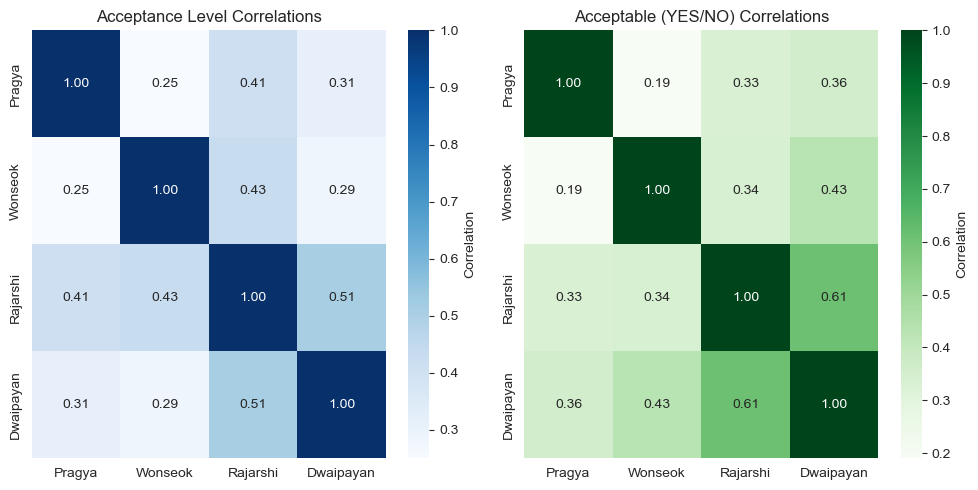

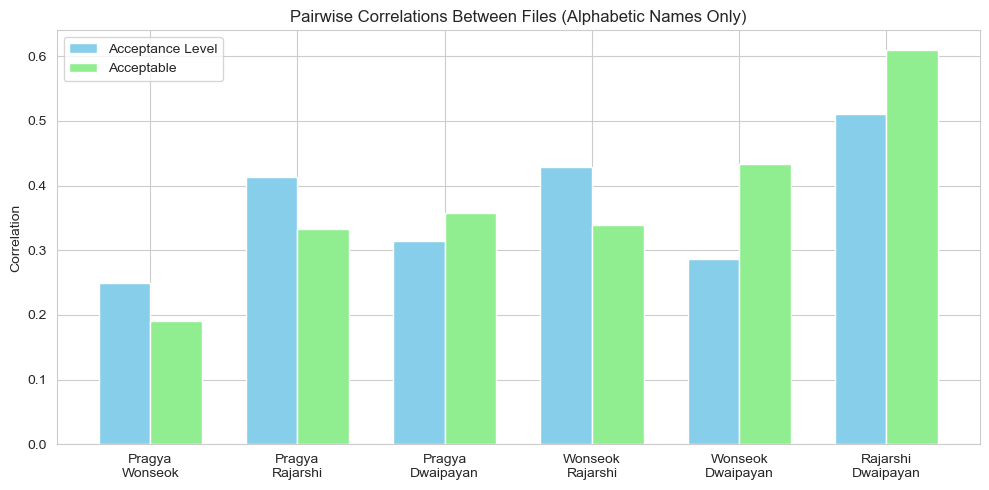

In [107]:
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re  # for cleaning filenames

files = [
    "/Users/prad7599/Documents/TesterCodes/Pragya.xlsx",
    "/Users/prad7599/Documents/TesterCodes/Wonseok.xlsx",
    "/Users/prad7599/Documents/TesterCodes/Rajarshi_46.xlsx",
    "/Users/prad7599/Documents/TesterCodes/Dwaipayan_43.xlsx"
]

# -------------------------
# 2. Read files into dicts
# -------------------------
dfs_level = {}
dfs_acc = {}
file_names_clean = []

for file in files:
    df = pd.read_excel(file)
    # Clean filename: remove path, extension, and keep only alphabets
    name_raw = os.path.splitext(os.path.basename(file))[0]
    name = re.sub(r'[^A-Za-z]', '', name_raw)  # keep only letters
    file_names_clean.append(name)

    # Acceptance Level
    df_level = df[["Folder_Name", "Acceptance Level"]].dropna(subset=["Folder_Name"])
    df_level["Acceptance Level"] = pd.to_numeric(df_level["Acceptance Level"], errors="coerce")
    df_level = df_level.rename(columns={"Acceptance Level": f"Acceptance_{name}"})
    dfs_level[name] = df_level

    # Acceptable YES/NO
    if "Acceptable" in df.columns:
        df_acc = df[["Folder_Name", "Acceptable"]].copy()
        df_acc["Acceptable"] = df_acc["Acceptable"].astype(str).str.upper().map({"YES":1,"NO":0})
        df_acc = df_acc.rename(columns={"Acceptable": f"Acceptable_{name}"})
        dfs_acc[name] = df_acc

# -------------------------
# 3. Compute all pairwise correlations
# -------------------------
pairs = list(itertools.combinations(file_names_clean, 2))
corr_level_dict = {}
corr_acc_dict = {}

for f1, f2 in pairs:
    # Merge Acceptance Level
    merged_level = pd.merge(dfs_level[f1], dfs_level[f2], on="Folder_Name", how="inner")
    corr_level = merged_level[f"Acceptance_{f1}"].corr(merged_level[f"Acceptance_{f2}"]) if len(merged_level) > 1 else np.nan
    corr_level_dict[(f1,f2)] = corr_level

    # Merge Acceptable if both present
    if f1 in dfs_acc and f2 in dfs_acc:
        merged_acc = pd.merge(dfs_acc[f1], dfs_acc[f2], on="Folder_Name", how="inner")
        corr_acc = merged_acc[f"Acceptable_{f1}"].corr(merged_acc[f"Acceptable_{f2}"]) if len(merged_acc) > 1 else np.nan
        corr_acc_dict[(f1,f2)] = corr_acc

# -------------------------
# 4. Prepare correlation matrices
# -------------------------
level_matrix = pd.DataFrame(index=file_names_clean, columns=file_names_clean, dtype=float)
acc_matrix = pd.DataFrame(index=file_names_clean, columns=file_names_clean, dtype=float)

for f1, f2 in pairs:
    level_matrix.loc[f1,f2] = corr_level_dict[(f1,f2)]
    level_matrix.loc[f2,f1] = corr_level_dict[(f1,f2)]
    if (f1,f2) in corr_acc_dict:
        acc_matrix.loc[f1,f2] = corr_acc_dict[(f1,f2)]
        acc_matrix.loc[f2,f1] = corr_acc_dict[(f1,f2)]

# Fill diagonals
for f in file_names_clean:
    level_matrix.loc[f,f] = 1.0
    acc_matrix.loc[f,f] = 1.0

# -------------------------
# 5. Plot heatmaps
# -------------------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(level_matrix, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label':'Correlation'})
plt.title("Acceptance Level Correlations")

plt.subplot(1,2,2)
sns.heatmap(acc_matrix, annot=True, fmt=".2f", cmap="Greens", cbar_kws={'label':'Correlation'})
plt.title("Acceptable (YES/NO) Correlations")
plt.tight_layout()
plt.show()

# -------------------------
# 6. Bar plot of pairwise correlations
# -------------------------
pair_labels = [f"{f1}\n{f2}" for f1,f2 in pairs]  # already cleaned names
level_values = [corr_level_dict[p] for p in pairs]
acc_values = [corr_acc_dict.get(p,np.nan) for p in pairs]

x = np.arange(len(pairs))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, level_values, width, label='Acceptance Level', color='skyblue')
plt.bar(x + width/2, acc_values, width, label='Acceptable', color='lightgreen')

plt.xticks(x, pair_labels, rotation=0, ha='center')
plt.ylabel("Correlation")
plt.title("Pairwise Correlations Between Files (Alphabetic Names Only)")
plt.legend()
plt.tight_layout()
plt.show()


YES points ranges:
L: -12.79 - 16.03
A: -12.79 - 16.03
B: -12.79 - 16.03

Ellipsoid center (scaled): [-0.10579739  0.53681204 -0.19122781]
Ellipsoid axes (scaled): [2. 2. 2.]

YES points inside: 88
YES points outside: 46
NO points inside: 51
NO points outside: 160


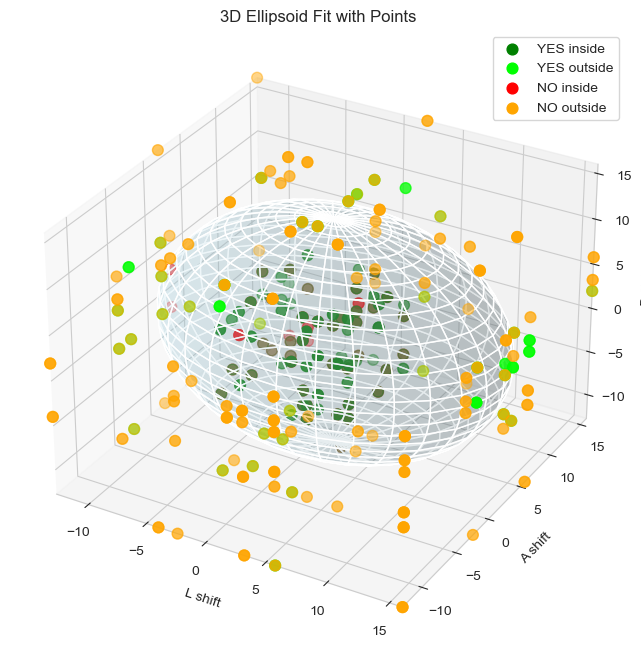

In [136]:
import pandas as pd
import numpy as np
import re
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# ----------------------------
# 1. Load Excel
# ----------------------------
file = "/Users/prad7599/Documents/TesterCodes/Pragya.xlsx"
df = pd.read_excel(file)

# ----------------------------
# 2. Parse Folder_Name for L, A, B, dE
# ----------------------------
pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"
def parse_name(name):
    m = re.search(pat, str(name))
    if m:
        return pd.Series([float(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))])
    return pd.Series([np.nan]*4)
df[["L","A","B","dE"]] = df["Folder_Name"].apply(parse_name)

# ----------------------------
# 3. Separate YES and NO points
# ----------------------------
df_yes = df[df["Acceptable"].astype(str).str.upper() == "YES"].dropna(subset=["L","A","B"])
df_no  = df[df["Acceptable"].astype(str).str.upper() == "NO"].dropna(subset=["L","A","B"])
X_yes = df_yes[["L","A","B"]].values
X_no  = df_no[["L","A","B"]].values

# ----------------------------
# 4. Print data ranges
# ----------------------------
print("YES points ranges:")
print("L:", X_yes[:,0].min(), "-", X_yes[:,0].max())
print("A:", X_yes[:,1].min(), "-", X_yes[:,1].max())
print("B:", X_yes[:,2].min(), "-", X_yes[:,2].max())

# ----------------------------
# 5. Scale data
# ----------------------------
scaler = StandardScaler()
X_yes_scaled = scaler.fit_transform(X_yes)
X_no_scaled = scaler.transform(X_no)

# ----------------------------
# 6. Ellipsoid fitting with bounds (center constrained)
# ----------------------------
def ellipsoid_residuals(params, points):
    x0, y0, z0, a, b, c = params
    return ((points[:,0]-x0)/a)**2 + ((points[:,1]-y0)/b)**2 + ((points[:,2]-z0)/c)**2 - 1

# Constrain center within scaled data range
min_scaled = X_yes_scaled.min(axis=0)
max_scaled = X_yes_scaled.max(axis=0)

lower_bounds = [min_scaled[0], min_scaled[1], min_scaled[2], 0.1, 0.1, 0.1]
upper_bounds = [max_scaled[0], max_scaled[1], max_scaled[2], 2.0, 2.0, 2.0]

res_ellipsoid = least_squares(
    ellipsoid_residuals,
    np.append(X_yes_scaled.mean(axis=0), X_yes_scaled.std(axis=0)),
    args=(X_yes_scaled,),
    bounds=(lower_bounds, upper_bounds)
)

ell_center_scaled = res_ellipsoid.x[:3]
ell_axes_scaled = res_ellipsoid.x[3:]

print("\nEllipsoid center (scaled):", ell_center_scaled)
print("Ellipsoid axes (scaled):", ell_axes_scaled)

# ----------------------------
# 7. Check inside/outside
# ----------------------------
def check_inside(points_scaled, center, axes):
    ell_val = ((points_scaled[:,0]-center[0])/axes[0])**2 + \
              ((points_scaled[:,1]-center[1])/axes[1])**2 + \
              ((points_scaled[:,2]-center[2])/axes[2])**2
    return ell_val <= 1

yes_inside_mask = check_inside(X_yes_scaled, ell_center_scaled, ell_axes_scaled)
no_inside_mask  = check_inside(X_no_scaled, ell_center_scaled, ell_axes_scaled)

print(f"\nYES points inside: {yes_inside_mask.sum()}")
print(f"YES points outside: {len(yes_inside_mask)-yes_inside_mask.sum()}")
print(f"NO points inside: {no_inside_mask.sum()}")
print(f"NO points outside: {len(no_inside_mask)-no_inside_mask.sum()}")

# ----------------------------
# 8. 3D Plot
# ----------------------------
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter points
ax.scatter(X_yes[yes_inside_mask,0], X_yes[yes_inside_mask,1], X_yes[yes_inside_mask,2],
           c='green', s=60, label='YES inside')
ax.scatter(X_yes[~yes_inside_mask,0], X_yes[~yes_inside_mask,1], X_yes[~yes_inside_mask,2],
           c='lime', s=60, label='YES outside')
ax.scatter(X_no[no_inside_mask,0], X_no[no_inside_mask,1], X_no[no_inside_mask,2],
           c='red', s=60, label='NO inside')
ax.scatter(X_no[~no_inside_mask,0], X_no[~no_inside_mask,1], X_no[~no_inside_mask,2],
           c='orange', s=60, label='NO outside')

# Mesh for ellipsoid
u = np.linspace(0, 2*np.pi, 30)
v = np.linspace(0, np.pi, 30)
xs = ell_center_scaled[0] + ell_axes_scaled[0]*np.outer(np.cos(u), np.sin(v))
ys = ell_center_scaled[1] + ell_axes_scaled[1]*np.outer(np.sin(u), np.sin(v))
zs = ell_center_scaled[2] + ell_axes_scaled[2]*np.outer(np.ones_like(u), np.cos(v))

# Inverse scale to original LAB units
ell_surface_scaled = np.vstack([xs.ravel(), ys.ravel(), zs.ravel()]).T
ell_surface_original = scaler.inverse_transform(ell_surface_scaled)
xs_orig = ell_surface_original[:,0].reshape(xs.shape)
ys_orig = ell_surface_original[:,1].reshape(ys.shape)
zs_orig = ell_surface_original[:,2].reshape(zs.shape)

ax.plot_surface(xs_orig, ys_orig, zs_orig, color='lightblue', alpha=0.2)

# Set axes limits based on data
ax.set_xlim(X_yes[:,0].min(), X_yes[:,0].max())
ax.set_ylim(X_yes[:,1].min(), X_yes[:,1].max())
ax.set_zlim(X_yes[:,2].min(), X_yes[:,2].max())

ax.set_xlabel('L shift')
ax.set_ylabel('A shift')
ax.set_zlabel('B shift')
ax.set_title('3D Ellipsoid Fit with Points')
ax.legend()
plt.show()


MSE: {'Sphere': np.float64(0.6279786118770103), 'Ellipsoid': np.float64(0.6803671538733794)}
Best shape: Sphere
YES inside: 63 YES outside: 71
NO inside: 75 NO outside: 136


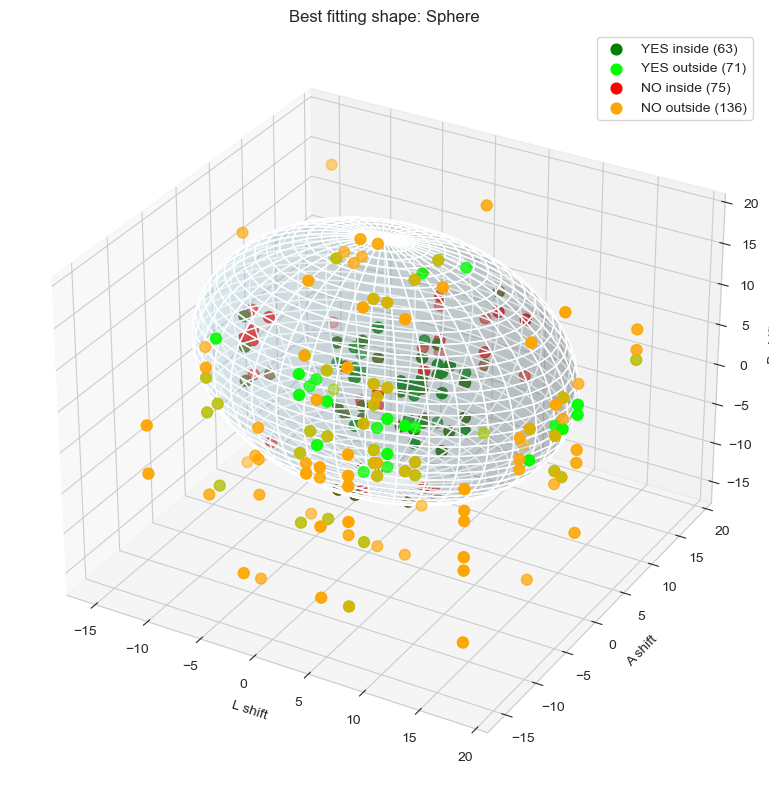

In [146]:
import pandas as pd
import numpy as np
import re
from scipy.optimize import least_squares
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---------------------------------------------------
# 1. Load Excel
# ---------------------------------------------------
file = "/Users/prad7599/Documents/TesterCodes/Pragya.xlsx"
df = pd.read_excel(file)

# ---------------------------------------------------
# 2. Parse folder names to extract L,a,b,dE
# ---------------------------------------------------
pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"

def parse_name(name):
    m = re.search(pat, str(name))
    if m:
        return pd.Series([float(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))])
    return pd.Series([np.nan]*4)

df[["L","A","B","dE"]] = df["Folder_Name"].apply(parse_name)

# ---------------------------------------------------
# 3. YES / NO separation
# ---------------------------------------------------
df_yes = df[df["Acceptable"].astype(str).str.upper() == "YES"].dropna(subset=["L","A","B"])
df_no  = df[df["Acceptable"].astype(str).str.upper() == "NO"].dropna(subset=["L","A","B"])

X_yes = df_yes[["L","A","B"]].values
X_no  = df_no[["L","A","B"]].values

# ---------------------------------------------------
# 4. Scale data
# ---------------------------------------------------
scaler = StandardScaler()
X_yes_scaled = scaler.fit_transform(X_yes)
X_no_scaled  = scaler.transform(X_no)

# ---------------------------------------------------
# 5. Sphere fitting
# ---------------------------------------------------
def sphere_residuals(params, points):
    x0, y0, z0, r = params
    return np.sqrt((points[:,0]-x0)**2 + (points[:,1]-y0)**2 + (points[:,2]-z0)**2) - r

x0_init = X_yes_scaled.mean(axis=0)
r_init  = np.mean(np.linalg.norm(X_yes_scaled - x0_init, axis=1))

res_sphere = least_squares(sphere_residuals, np.append(x0_init, r_init), args=(X_yes_scaled,))
mse_sphere = np.mean(sphere_residuals(res_sphere.x, X_yes_scaled)**2)

# ---------------------------------------------------
# 6. Ellipsoid fitting
# ---------------------------------------------------
def ellipsoid_residuals(params, points):
    x0, y0, z0, a, b, c = params
    return ((points[:,0]-x0)/a)**2 + ((points[:,1]-y0)/b)**2 + ((points[:,2]-z0)/c)**2 - 1

min_scaled = X_yes_scaled.min(axis=0)
max_scaled = X_yes_scaled.max(axis=0)

lower_bounds = [min_scaled[0], min_scaled[1], min_scaled[2], 0.1, 0.1, 0.1]
upper_bounds = [max_scaled[0], max_scaled[1], max_scaled[2], 2.0, 2.0, 2.0]

init_ell = np.append(X_yes_scaled.mean(axis=0), X_yes_scaled.std(axis=0))

res_ellipsoid = least_squares(
    ellipsoid_residuals,
    init_ell,
    args=(X_yes_scaled,),
    bounds=(lower_bounds, upper_bounds)
)
mse_ellipsoid = np.mean(ellipsoid_residuals(res_ellipsoid.x, X_yes_scaled)**2)

# ---------------------------------------------------
# 7. Select better shape
# ---------------------------------------------------
mse_dict = {"Sphere": mse_sphere, "Ellipsoid": mse_ellipsoid}
best_shape = min(mse_dict, key=mse_dict.get)

print("MSE:", mse_dict)
print("Best shape:", best_shape)

# ---------------------------------------------------
# 8. Inside / Outside classification
# ---------------------------------------------------
def inside_sphere(points, params):
    x0, y0, z0, r = params
    return np.linalg.norm(points - np.array([x0,y0,z0]), axis=1) <= r

def inside_ellipsoid(points, params):
    x0, y0, z0, a, b, c = params
    v = ((points[:,0]-x0)/a)**2 + ((points[:,1]-y0)/b)**2 + ((points[:,2]-z0)/c)**2
    return v <= 1

if best_shape == "Sphere":
    P = res_sphere.x
    yes_mask = inside_sphere(X_yes_scaled, P)
    no_mask  = inside_sphere(X_no_scaled, P)
else:
    P = res_ellipsoid.x
    yes_mask = inside_ellipsoid(X_yes_scaled, P)
    no_mask  = inside_ellipsoid(X_no_scaled, P)

yes_in  = X_yes[yes_mask]
yes_out = X_yes[~yes_mask]
no_in   = X_no[no_mask]
no_out  = X_no[~no_mask]

print("YES inside:", len(yes_in), "YES outside:", len(yes_out))
print("NO inside:", len(no_in),  "NO outside:", len(no_out))

# ---------------------------------------------------
# 9. 3D Plot + legend counts
# ---------------------------------------------------
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

label_yes_in  = f"YES inside ({len(yes_in)})"
label_yes_out = f"YES outside ({len(yes_out)})"
label_no_in   = f"NO inside ({len(no_in)})"
label_no_out  = f"NO outside ({len(no_out)})"

ax.scatter(yes_in[:,0],  yes_in[:,1],  yes_in[:,2],  c="green",  s=60, label=label_yes_in)
ax.scatter(yes_out[:,0], yes_out[:,1], yes_out[:,2], c="lime",   s=60, label=label_yes_out)
ax.scatter(no_in[:,0],   no_in[:,1],   no_in[:,2],   c="red",    s=60, label=label_no_in)
ax.scatter(no_out[:,0],  no_out[:,1],  no_out[:,2],  c="orange", s=60, label=label_no_out)

# ---------------------------------------------------
# 10. Plot shape (sphere or ellipsoid)
# ---------------------------------------------------
u = np.linspace(0, 2*np.pi, 40)
v = np.linspace(0, np.pi, 40)

if best_shape == "Sphere":
    x0, y0, z0, r = P
    xs = x0 + r*np.outer(np.cos(u), np.sin(v))
    ys = y0 + r*np.outer(np.sin(u), np.sin(v))
    zs = z0 + r*np.outer(np.ones_like(u), np.cos(v))
else:
    x0, y0, z0, a, b, c = P
    xs = x0 + a*np.outer(np.cos(u), np.sin(v))
    ys = y0 + b*np.outer(np.sin(u), np.sin(v))
    zs = z0 + c*np.outer(np.ones_like(u), np.cos(v))

surface_scaled = np.vstack([xs.ravel(), ys.ravel(), zs.ravel()]).T
surface_orig   = scaler.inverse_transform(surface_scaled)

xs_o = surface_orig[:,0].reshape(xs.shape)
ys_o = surface_orig[:,1].reshape(ys.shape)
zs_o = surface_orig[:,2].reshape(zs.shape)

ax.plot_surface(xs_o, ys_o, zs_o, color="lightblue", alpha=0.2)

# ---------------------------------------------------
# Axis labels
# ---------------------------------------------------
ax.set_xlabel("L shift")
ax.set_ylabel("A shift")
ax.set_zlabel("B shift")
ax.set_title(f"Best fitting shape: {best_shape}")

# ---------------------------------------------------
#  FIX: Prevent B-shift from being cut off
# ---------------------------------------------------
x_min, x_max = df["L"].min(), df["L"].max()
y_min, y_max = df["A"].min(), df["A"].max()
z_min, z_max = df["B"].min(), df["B"].max()

pad = 5

ax.set_xlim(x_min - pad, x_max + pad)
ax.set_ylim(y_min - pad, y_max + pad)
ax.set_zlim(z_min - pad, z_max + pad)

# ---------------------------------------------------
ax.legend()
plt.tight_layout()
plt.show()


MSE: {'Sphere': np.float64(0.6279786118770103), 'Ellipsoid': np.float64(0.6803671538733794)}
Best shape: Sphere
YES inside: 63 YES outside: 71
NO inside: 75 NO outside: 136


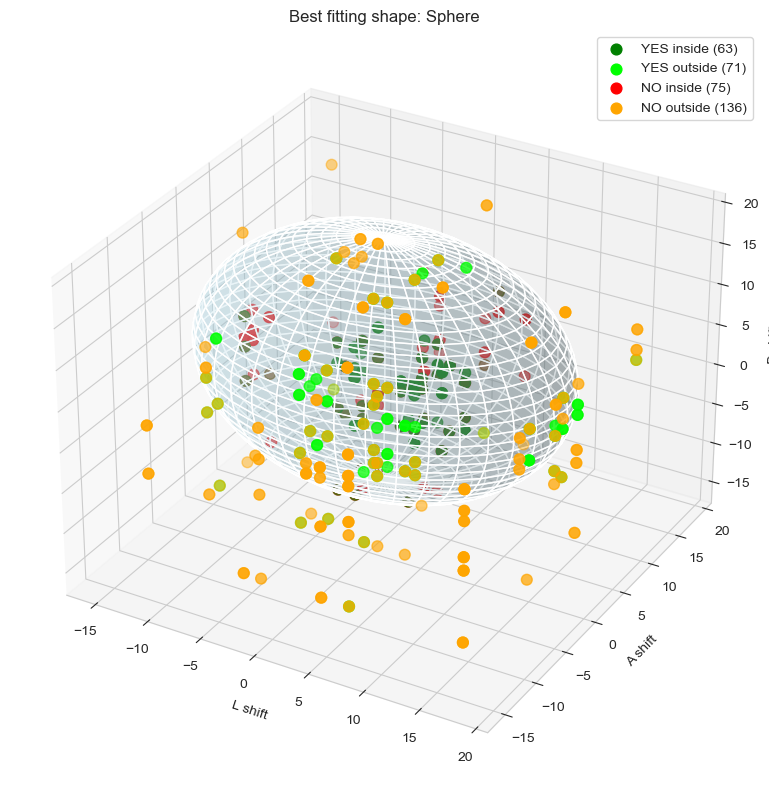


GIF saved to: /Users/prad7599/Documents/TesterCodes/rotating_shape.gif



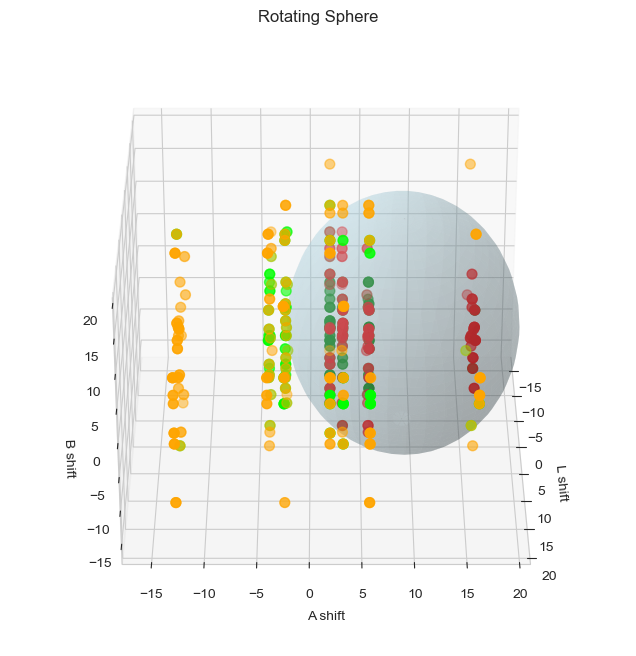

In [148]:
import pandas as pd
import numpy as np
import re
from scipy.optimize import least_squares
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# ---------------------------------------------------
# 1. Load Excel
# ---------------------------------------------------
file = "/Users/prad7599/Documents/TesterCodes/Pragya.xlsx"
df = pd.read_excel(file)

# ---------------------------------------------------
# 2. Parse folder names to extract L,a,b,dE
# ---------------------------------------------------
pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"

def parse_name(name):
    m = re.search(pat, str(name))
    if m:
        return pd.Series([float(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))])
    return pd.Series([np.nan]*4)

df[["L","A","B","dE"]] = df["Folder_Name"].apply(parse_name)

# ---------------------------------------------------
# 3. YES / NO separation
# ---------------------------------------------------
df_yes = df[df["Acceptable"].astype(str).str.upper() == "YES"].dropna(subset=["L","A","B"])
df_no  = df[df["Acceptable"].astype(str).str.upper() == "NO"].dropna(subset=["L","A","B"])

X_yes = df_yes[["L","A","B"]].values
X_no  = df_no[["L","A","B"]].values

# ---------------------------------------------------
# 4. Scale data
# ---------------------------------------------------
scaler = StandardScaler()
X_yes_scaled = scaler.fit_transform(X_yes)
X_no_scaled  = scaler.transform(X_no)

# ---------------------------------------------------
# 5. Sphere fitting
# ---------------------------------------------------
def sphere_residuals(params, points):
    x0, y0, z0, r = params
    return np.sqrt((points[:,0]-x0)**2 + (points[:,1]-y0)**2 + (points[:,2]-z0)**2) - r

x0_init = X_yes_scaled.mean(axis=0)
r_init  = np.mean(np.linalg.norm(X_yes_scaled - x0_init, axis=1))

res_sphere = least_squares(sphere_residuals, np.append(x0_init, r_init), args=(X_yes_scaled,))
mse_sphere = np.mean(sphere_residuals(res_sphere.x, X_yes_scaled)**2)

# ---------------------------------------------------
# 6. Ellipsoid fitting
# ---------------------------------------------------
def ellipsoid_residuals(params, points):
    x0, y0, z0, a, b, c = params
    return ((points[:,0]-x0)/a)**2 + ((points[:,1]-y0)/b)**2 + ((points[:,2]-z0)/c)**2 - 1

min_scaled = X_yes_scaled.min(axis=0)
max_scaled = X_yes_scaled.max(axis=0)

lower_bounds = [min_scaled[0], min_scaled[1], min_scaled[2], 0.1, 0.1, 0.1]
upper_bounds = [max_scaled[0], max_scaled[1], max_scaled[2], 2.0, 2.0, 2.0]

init_ell = np.append(X_yes_scaled.mean(axis=0), X_yes_scaled.std(axis=0))

res_ellipsoid = least_squares(
    ellipsoid_residuals,
    init_ell,
    args=(X_yes_scaled,),
    bounds=(lower_bounds, upper_bounds)
)
mse_ellipsoid = np.mean(ellipsoid_residuals(res_ellipsoid.x, X_yes_scaled)**2)

# ---------------------------------------------------
# 7. Select better shape
# ---------------------------------------------------
mse_dict = {"Sphere": mse_sphere, "Ellipsoid": mse_ellipsoid}
best_shape = min(mse_dict, key=mse_dict.get)

print("MSE:", mse_dict)
print("Best shape:", best_shape)

# ---------------------------------------------------
# 8. Inside / Outside classification
# ---------------------------------------------------
def inside_sphere(points, params):
    x0, y0, z0, r = params
    return np.linalg.norm(points - np.array([x0,y0,z0]), axis=1) <= r

def inside_ellipsoid(points, params):
    x0, y0, z0, a, b, c = params
    v = ((points[:,0]-x0)/a)**2 + ((points[:,1]-y0)/b)**2 + ((points[:,2]-z0)/c)**2
    return v <= 1

if best_shape == "Sphere":
    P = res_sphere.x
    yes_mask = inside_sphere(X_yes_scaled, P)
    no_mask  = inside_sphere(X_no_scaled, P)
else:
    P = res_ellipsoid.x
    yes_mask = inside_ellipsoid(X_yes_scaled, P)
    no_mask  = inside_ellipsoid(X_no_scaled, P)

yes_in  = X_yes[yes_mask]
yes_out = X_yes[~yes_mask]
no_in   = X_no[no_mask]
no_out  = X_no[~no_mask]

print("YES inside:", len(yes_in), "YES outside:", len(yes_out))
print("NO inside:", len(no_in),  "NO outside:", len(no_out))

# ---------------------------------------------------
# 9. 3D Plot + legend counts
# ---------------------------------------------------
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

label_yes_in  = f"YES inside ({len(yes_in)})"
label_yes_out = f"YES outside ({len(yes_out)})"
label_no_in   = f"NO inside ({len(no_in)})"
label_no_out  = f"NO outside ({len(no_out)})"

ax.scatter(yes_in[:,0],  yes_in[:,1],  yes_in[:,2],  c="green",  s=60, label=label_yes_in)
ax.scatter(yes_out[:,0], yes_out[:,1], yes_out[:,2], c="lime",   s=60, label=label_yes_out)
ax.scatter(no_in[:,0],   no_in[:,1],   no_in[:,2],   c="red",    s=60, label=label_no_in)
ax.scatter(no_out[:,0],  no_out[:,1],  no_out[:,2],  c="orange", s=60, label=label_no_out)

# ---------------------------------------------------
# 10. Plot shape (sphere or ellipsoid)
# ---------------------------------------------------
u = np.linspace(0, 2*np.pi, 40)
v = np.linspace(0, np.pi, 40)

if best_shape == "Sphere":
    x0, y0, z0, r = P
    xs = x0 + r*np.outer(np.cos(u), np.sin(v))
    ys = y0 + r*np.outer(np.sin(u), np.sin(v))
    zs = z0 + r*np.outer(np.ones_like(u), np.cos(v))
else:
    x0, y0, z0, a, b, c = P
    xs = x0 + a*np.outer(np.cos(u), np.sin(v))
    ys = y0 + b*np.outer(np.sin(u), np.sin(v))
    zs = z0 + c*np.outer(np.ones_like(u), np.cos(v))

surface_scaled = np.vstack([xs.ravel(), ys.ravel(), zs.ravel()]).T
surface_orig   = scaler.inverse_transform(surface_scaled)

xs_o = surface_orig[:,0].reshape(xs.shape)
ys_o = surface_orig[:,1].reshape(ys.shape)
zs_o = surface_orig[:,2].reshape(zs.shape)

ax.plot_surface(xs_o, ys_o, zs_o, color="lightblue", alpha=0.25)

# ---------------------------------------------------
# FIX: B-axis cutoff
# ---------------------------------------------------
x_min, x_max = df["L"].min(), df["L"].max()
y_min, y_max = df["A"].min(), df["A"].max()
z_min, z_max = df["B"].min(), df["B"].max()

pad = 5

ax.set_xlim(x_min - pad, x_max + pad)
ax.set_ylim(y_min - pad, y_max + pad)
ax.set_zlim(z_min - pad, z_max + pad)

ax.set_xlabel("L shift")
ax.set_ylabel("A shift")
ax.set_zlabel("B shift")
ax.set_title(f"Best fitting shape: {best_shape}")
ax.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 11. Rotating GIF animation
# ---------------------------------------------------
fig2 = plt.figure(figsize=(10,8))
ax2 = fig2.add_subplot(111, projection='3d')

# Points
ax2.scatter(yes_in[:,0],  yes_in[:,1],  yes_in[:,2],  c="green",  s=50)
ax2.scatter(yes_out[:,0], yes_out[:,1], yes_out[:,2], c="lime",   s=50)
ax2.scatter(no_in[:,0],   no_in[:,1],   no_in[:,2],   c="red",    s=50)
ax2.scatter(no_out[:,0],  no_out[:,1],  no_out[:,2],  c="orange", s=50)

# Shape
ax2.plot_surface(xs_o, ys_o, zs_o, rstride=1, cstride=1,
                 color="lightblue", alpha=0.25, linewidth=0)

ax2.set_xlim(x_min - pad, x_max + pad)
ax2.set_ylim(y_min - pad, y_max + pad)
ax2.set_zlim(z_min - pad, z_max + pad)

ax2.set_xlabel("L shift")
ax2.set_ylabel("A shift")
ax2.set_zlabel("B shift")
ax2.set_title(f"Rotating {best_shape}")

# Rotate function
def rotate(angle):
    ax2.view_init(elev=30, azim=angle)

# Create GIF
anim = animation.FuncAnimation(fig2, rotate, frames=np.arange(0, 360, 2), interval=80)

gif_path = "/Users/prad7599/Documents/TesterCodes/rotating_shape.gif"
anim.save(gif_path, writer="pillow", fps=15)

print(f"\nGIF saved to: {gif_path}\n")


Fitted sphere parameters (scaled): [-0.79135982  1.68347603 -0.33271179  2.43783929]
Inside points: 63
Outside points: 71


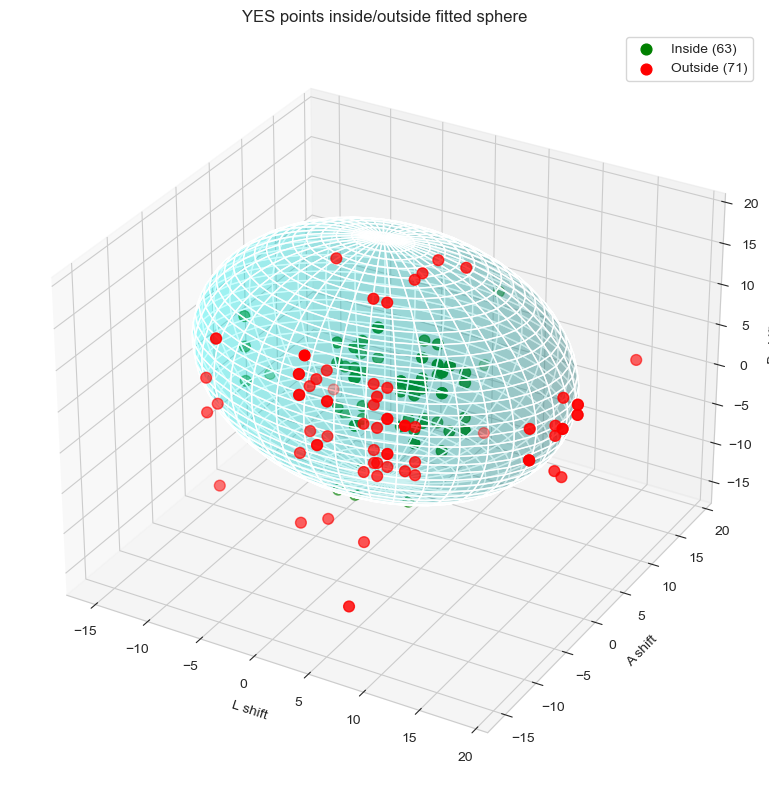

In [154]:
import pandas as pd
import numpy as np
import re
from scipy.optimize import least_squares
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. Load Excel
# ---------------------------------------------------
file = "/Users/prad7599/Documents/TesterCodes/Pragya.xlsx"
df = pd.read_excel(file)

# ---------------------------------------------------
# 2. Parse folder names to extract L,a,b,dE
# ---------------------------------------------------
pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"

def parse_name(name):
    m = re.search(pat, str(name))
    if m:
        return pd.Series([float(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))])
    return pd.Series([np.nan]*4)

df[["L","A","B","dE"]] = df["Folder_Name"].apply(parse_name)

# ---------------------------------------------------
# 3. Filter YES points only
# ---------------------------------------------------
df_yes = df[df["Acceptable"].astype(str).str.upper() == "YES"].dropna(subset=["L","A","B"])
X_yes = df_yes[["L","A","B"]].values

# ---------------------------------------------------
# 4. Scale YES points
# ---------------------------------------------------
scaler = StandardScaler()
X_yes_scaled = scaler.fit_transform(X_yes)

# ---------------------------------------------------
# 5. Sphere fitting for YES points
# ---------------------------------------------------
def sphere_residuals(params, points):
    x0, y0, z0, r = params
    return np.linalg.norm(points - np.array([x0,y0,z0]), axis=1) - r

x0_init = X_yes_scaled.mean(axis=0)
r_init  = np.mean(np.linalg.norm(X_yes_scaled - x0_init, axis=1))

res_sphere = least_squares(sphere_residuals, np.append(x0_init, r_init), args=(X_yes_scaled,))
x0, y0, z0, r = res_sphere.x
print("Fitted sphere parameters (scaled):", res_sphere.x)

# ---------------------------------------------------
# 6. Classify inside / outside points
# ---------------------------------------------------
distances = np.linalg.norm(X_yes_scaled - np.array([x0, y0, z0]), axis=1)
inside_mask = distances <= r
outside_mask = ~inside_mask

X_yes_in = X_yes[inside_mask]
X_yes_out = X_yes[outside_mask]

print("Inside points:", len(X_yes_in))
print("Outside points:", len(X_yes_out))

# ---------------------------------------------------
# 7. Plot YES points & fitted sphere
# ---------------------------------------------------
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot inside points
ax.scatter(X_yes_in[:,0], X_yes_in[:,1], X_yes_in[:,2],
           c="green", s=60, label=f"Inside ({len(X_yes_in)})")

# Plot outside points
ax.scatter(X_yes_out[:,0], X_yes_out[:,1], X_yes_out[:,2],
           c="red", s=60, label=f"Outside ({len(X_yes_out)})")

# Plot sphere surface
u = np.linspace(0, 2*np.pi, 40)
v = np.linspace(0, np.pi, 40)
xs = x0 + r*np.outer(np.cos(u), np.sin(v))
ys = y0 + r*np.outer(np.sin(u), np.sin(v))
zs = z0 + r*np.outer(np.ones_like(u), np.cos(v))

# Convert back to original scale
surface_scaled = np.vstack([xs.ravel(), ys.ravel(), zs.ravel()]).T
surface_orig = scaler.inverse_transform(surface_scaled)
xs_o = surface_orig[:,0].reshape(xs.shape)
ys_o = surface_orig[:,1].reshape(ys.shape)
zs_o = surface_orig[:,2].reshape(zs.shape)
ax.plot_surface(xs_o, ys_o, zs_o, color="cyan", alpha=0.2)

# ---------------------------------------------------
# Axis labels & limits
# ---------------------------------------------------
ax.set_xlabel("L shift")
ax.set_ylabel("A shift")
ax.set_zlabel("B shift")
ax.set_title("YES points inside/outside fitted sphere")
ax.legend()

pad = 5
ax.set_xlim(df["L"].min()-pad, df["L"].max()+pad)
ax.set_ylim(df["A"].min()-pad, df["A"].max()+pad)
ax.set_zlim(df["B"].min()-pad, df["B"].max()+pad)

plt.tight_layout()
plt.show()


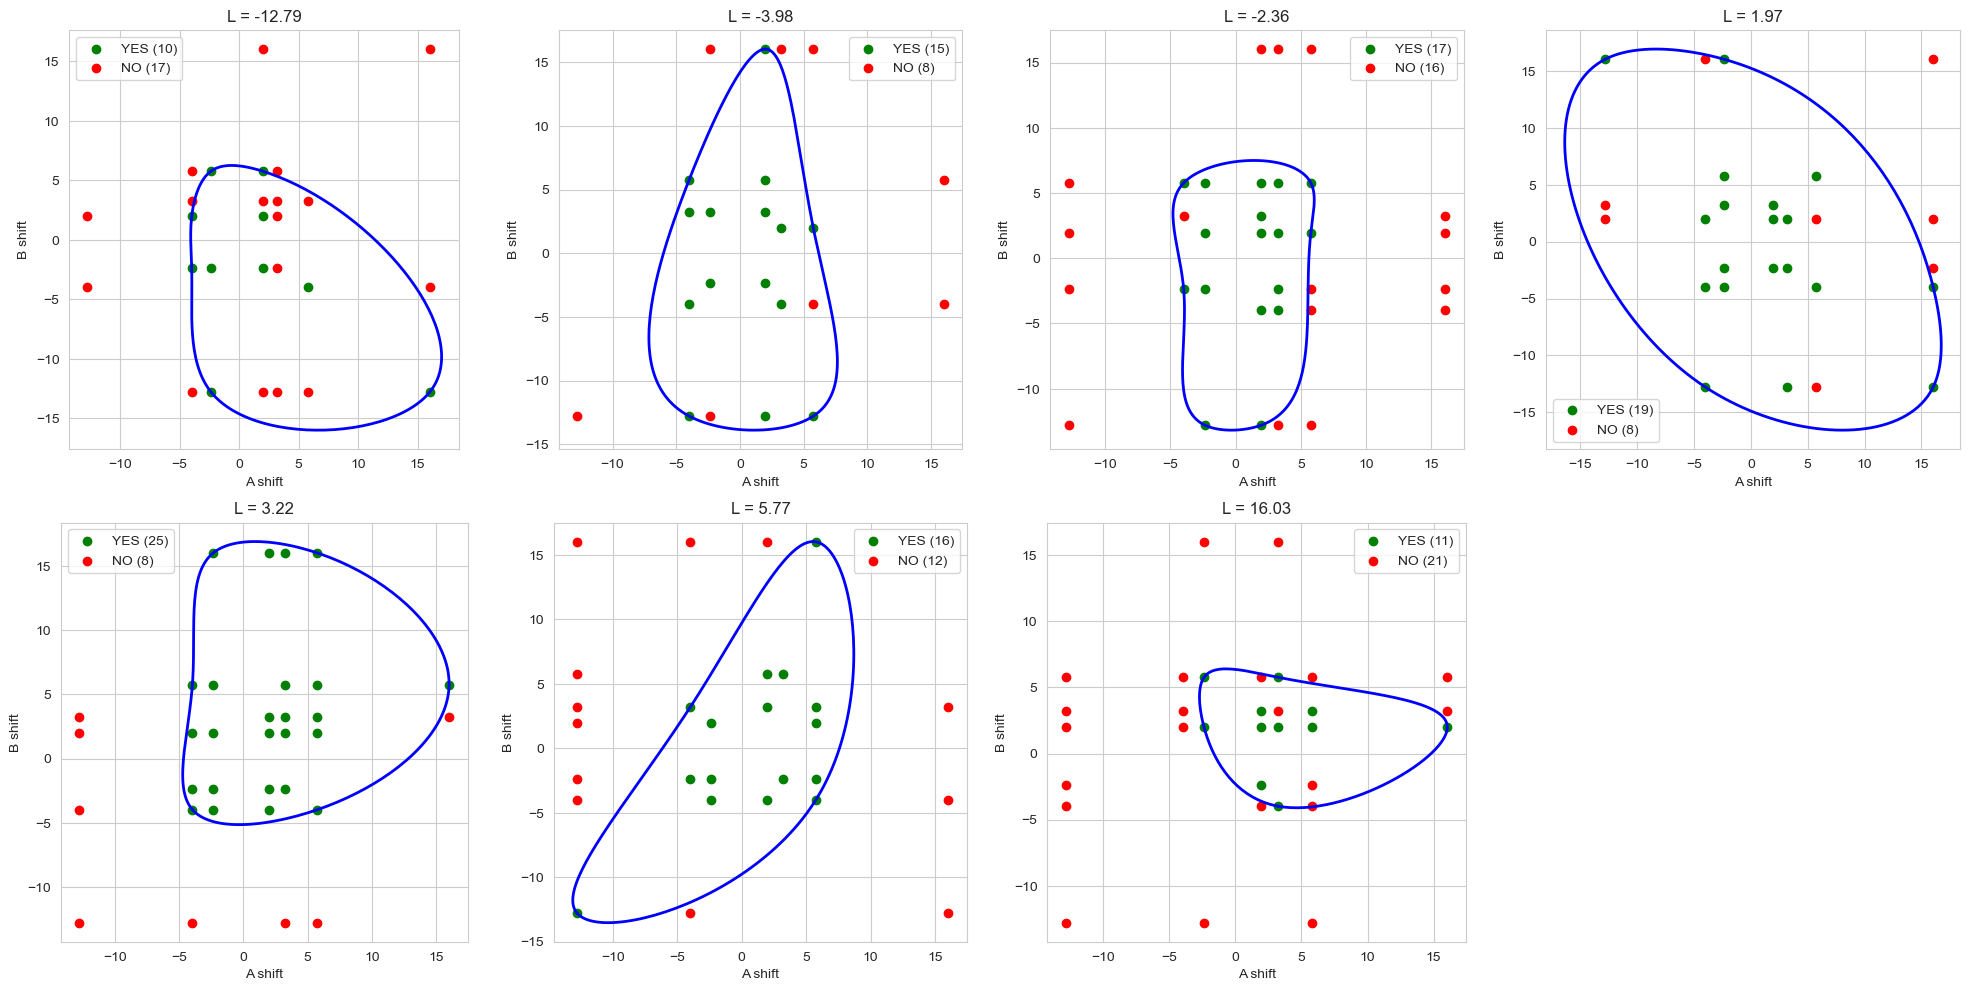

In [175]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev

# ---------------------------------------------------
# 1. Load Excel
# ---------------------------------------------------
file = "/Users/prad7599/Documents/TesterCodes/Pragya.xlsx"
df = pd.read_excel(file)

# ---------------------------------------------------
# 2. Parse folder names to extract L,a,b,dE
# ---------------------------------------------------
pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"

def parse_name(name):
    m = re.search(pat, str(name))
    if m:
        return pd.Series([float(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))])
    return pd.Series([np.nan]*4)

df[["L","A","B","dE"]] = df["Folder_Name"].apply(parse_name)

# ---------------------------------------------------
# 3. Keep unique rows, prioritize YES over NO
# ---------------------------------------------------
df.sort_values("Acceptable", ascending=False, inplace=True)  # YES first
df = df.drop_duplicates(subset=["L","A","B"], keep="first")

# ---------------------------------------------------
# 4. Prepare L values
# ---------------------------------------------------
L_values = sorted(df["L"].unique())

# ---------------------------------------------------
# 5. Plot per L with smooth decision boundary
# ---------------------------------------------------
ncols = 4
nrows = int(np.ceil(len(L_values)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(20,5*nrows))
axes = axes.flatten()

for i, L in enumerate(L_values):
    ax = axes[i]
    df_L = df[df["L"] == L]
    X_yes = df_L[df_L["Acceptable"].str.upper() == "YES"][["A","B"]].values
    X_no  = df_L[df_L["Acceptable"].str.upper() == "NO"][["A","B"]].values

    # Scatter points
    if len(X_yes) > 0:
        ax.scatter(X_yes[:,0], X_yes[:,1], c="green", label=f"YES ({len(X_yes)})")
    if len(X_no) > 0:
        ax.scatter(X_no[:,0], X_no[:,1], c="red", label=f"NO ({len(X_no)})")

    # Smooth boundary using convex hull + spline
    if len(X_yes) >= 3:
        hull = ConvexHull(X_yes)
        hull_points = X_yes[hull.vertices]  # ordered points of hull

        # Close the loop
        hull_points = np.vstack([hull_points, hull_points[0]])

        # Spline interpolation
        tck, u = splprep([hull_points[:,0], hull_points[:,1]], s=0, per=True)
        u_fine = np.linspace(0, 1, 200)
        x_smooth, y_smooth = splev(u_fine, tck)

        ax.plot(x_smooth, y_smooth, 'b-', lw=2)

    ax.set_title(f"L = {L}")
    ax.set_xlabel("A shift")
    ax.set_ylabel("B shift")
    ax.legend()
    ax.set_aspect('equal')

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Saved plot to /Users/prad7599/Documents/TesterCodes/Plots/CurveAFits/Dwaipayan_43_plot.png


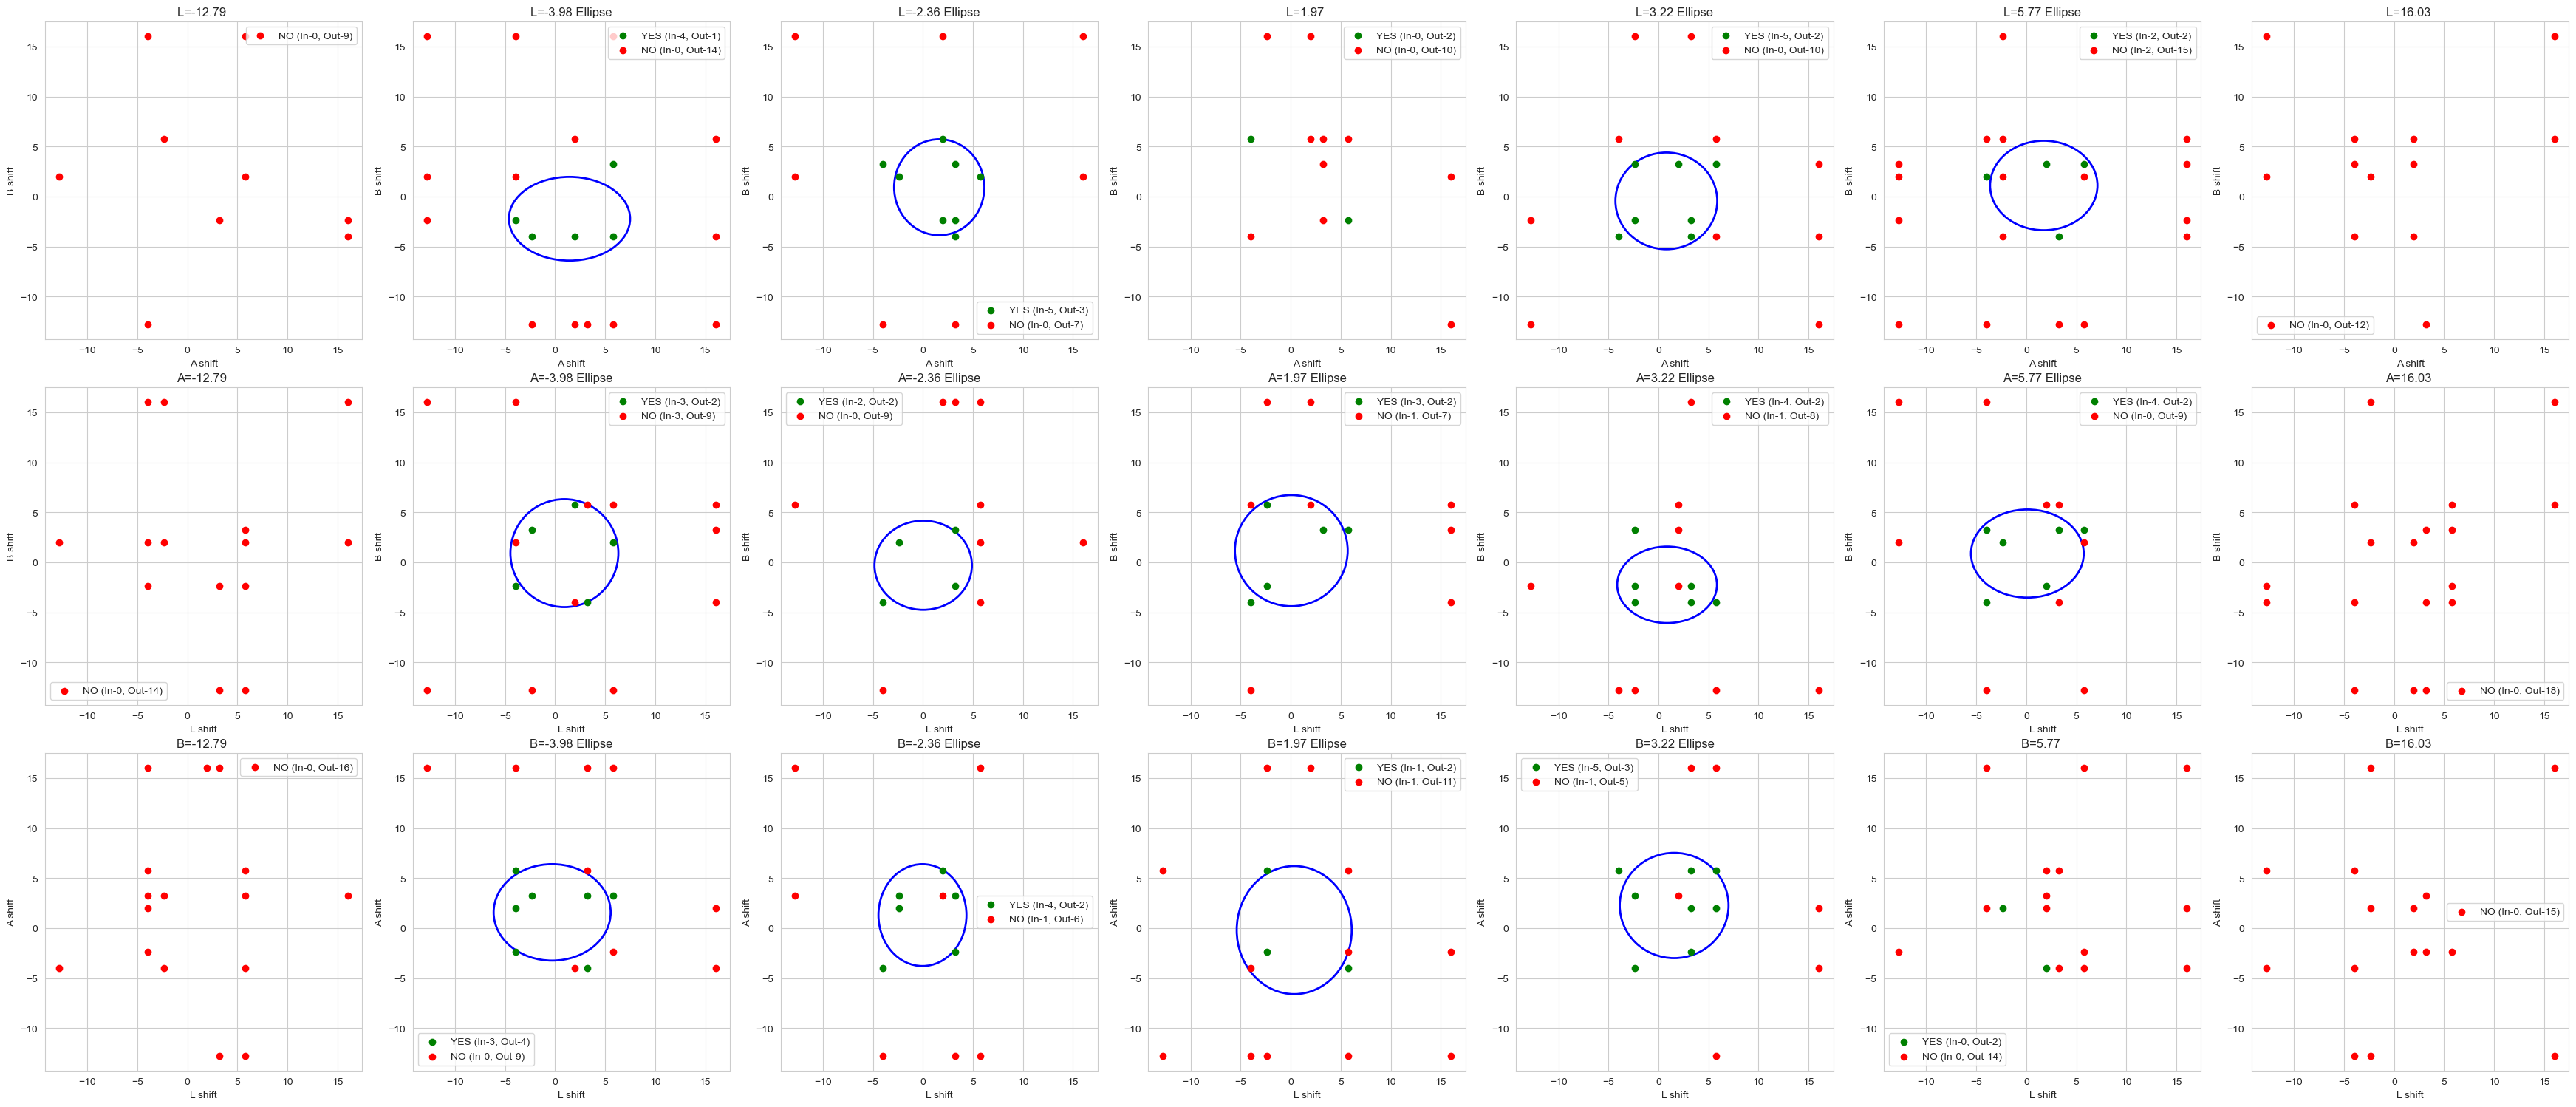

In [200]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import least_squares
import os

def plot_combined_ls(file_path, output_folder=None, max_scaling=3.0, score_thresh=0.5):
    """
    Plot all splits (L, A, B) in a combined figure.
    Fit ellipse using least squares to maximize separation.
    Saves the plot in the specified output folder. If None, saves in same folder as the Excel file.
    """
    # ---------------------------------------------------
    # 1. Load Excel
    # ---------------------------------------------------
    df = pd.read_excel(file_path)

    # ---------------------------------------------------
    # 2. Parse folder names
    # ---------------------------------------------------
    pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"

    def parse_name(name):
        m = re.search(pat, str(name))
        if m:
            return pd.Series([float(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))])
        return pd.Series([np.nan]*4)

    df[["L","A","B","dE"]] = df["Folder_Name"].apply(parse_name)

    # ---------------------------------------------------
    # 3. Remove duplicates, YES preferred
    # ---------------------------------------------------
    df.sort_values("Acceptable", ascending=False, inplace=True)
    df = df.drop_duplicates(subset=["L","A","B"], keep="first")

    # ---------------------------------------------------
    # 4. Setup figure: 3 rows × max number of splits
    # ---------------------------------------------------
    splits = ['L','A','B']
    split_values_list = [sorted(df[s].unique()) for s in splits]
    ncols = max(len(vals) for vals in split_values_list)
    nrows = 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))
    axes = axes.reshape(nrows, ncols)

    axis_ranges = {
        'L': ('A','B'),
        'A': ('L','B'),
        'B': ('L','A')
    }
    global_limits = {}
    for s in splits:
        x_col, y_col = axis_ranges[s]
        x_min, x_max = df[x_col].min(), df[x_col].max()
        y_min, y_max = df[y_col].min(), df[y_col].max()
        pad_x = 0.05*(x_max-x_min)
        pad_y = 0.05*(y_max-y_min)
        global_limits[s] = (x_min-pad_x, x_max+pad_x, y_min-pad_y, y_max+pad_y)

    # ---------------------------------------------------
    # 5. Function: points inside ellipse
    # ---------------------------------------------------
    def in_ellipse(points, h, k, a, b):
        if a<=0 or b<=0 or len(points)==0:
            return np.zeros(len(points), dtype=bool)
        return ((points[:,0]-h)**2 / a**2 + (points[:,1]-k)**2 / b**2) <= 1

    # ---------------------------------------------------
    # 6. Loop through splits
    # ---------------------------------------------------
    for row_idx, split_col in enumerate(splits):
        x_col, y_col = axis_ranges[split_col]
        split_values = split_values_list[row_idx]

        for col_idx in range(ncols):
            ax = axes[row_idx, col_idx]
            if col_idx >= len(split_values):
                ax.axis('off')
                continue

            val = split_values[col_idx]
            df_val = df[df[split_col]==val]
            X_yes = df_val[df_val["Acceptable"].str.upper()=='YES'][[x_col,y_col]].values
            X_no  = df_val[df_val["Acceptable"].str.upper()=='NO'][[x_col,y_col]].values

            ell_label = ""
            yes_in_mask = np.zeros(len(X_yes), dtype=bool)
            no_in_mask = np.zeros(len(X_no), dtype=bool)

            # ---------------------------------------------------
            # Fit ellipse using least squares if enough points
            # ---------------------------------------------------
            if len(X_yes)>=3:
                def objective(p):
                    h,k,a,b = p
                    y_in = in_ellipse(X_yes, h,k,a,b)
                    n_in = in_ellipse(X_no, h,k,a,b)
                    denom = (len(X_yes)-y_in.sum()) + n_in.sum()
                    if denom==0: return -1.0
                    return -((y_in.sum() + len(X_no)-n_in.sum()) / denom)

                mean = X_yes.mean(axis=0)
                stds = X_yes.std(axis=0)*1.5
                init_guess = [mean[0], mean[1], stds[0], stds[1]]

                res = least_squares(objective, init_guess, bounds=([min(df[x_col]),min(df[y_col]),1e-2,1e-2],
                                                                   [max(df[x_col]),max(df[y_col]),(max(df[x_col])-min(df[x_col]))*2,
                                                                    (max(df[y_col])-min(df[y_col]))*2]))
                h,k,a,b = res.x
                yes_in_mask = in_ellipse(X_yes, h,k,a,b)
                no_in_mask  = in_ellipse(X_no, h,k,a,b)
                score = -res.fun

                if score>score_thresh:
                    ell = Ellipse(xy=(h,k), width=2*a, height=2*b, edgecolor='blue', fc='None', lw=2)
                    ax.add_patch(ell)
                    ell_label = f"Ellipse"

            # Scatter points
            yes_label = f"YES (In-{yes_in_mask.sum()}, Out-{len(X_yes)-yes_in_mask.sum()})"
            no_label  = f"NO (In-{no_in_mask.sum()}, Out-{len(X_no)-no_in_mask.sum()})"
            if len(X_yes)>0:
                ax.scatter(X_yes[:,0], X_yes[:,1], c="green", label=yes_label)
            if len(X_no)>0:
                ax.scatter(X_no[:,0], X_no[:,1], c="red", label=no_label)

            x_min, x_max, y_min, y_max = global_limits[split_col]
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f"{split_col}={val} {ell_label}")
            ax.set_xlabel(f"{x_col} shift")
            ax.set_ylabel(f"{y_col} shift")
            ax.legend()
            ax.set_aspect('equal')

    plt.tight_layout()
    
    # ---------------------------------------------------
    # Save figure in output folder if specified
    # ---------------------------------------------------
    base_name = os.path.basename(file_path)
    name_no_ext = os.path.splitext(base_name)[0]
    if output_folder is None:
        output_folder = os.path.dirname(file_path)
    os.makedirs(output_folder, exist_ok=True)
    save_path = os.path.join(output_folder, f"{name_no_ext}_plot.png")
    plt.savefig(save_path, dpi=300)
    print(f"Saved plot to {save_path}")
    plt.show()


# ---------------------------------------------------
# Example usage
# ---------------------------------------------------
file_path = "/Users/prad7599/Documents/TesterCodes/Dwaipayan_43.xlsx"
output_folder = "/Users/prad7599/Documents/TesterCodes/Plots/CurveAFits"
plot_combined_ls(file_path, output_folder=output_folder)


In [210]:
import pandas as pd
import numpy as np
import re
from scipy.optimize import least_squares
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

def plot_3d_sphere(file_path, output_folder):
    """
    Fits a sphere to YES points in 3D (L,A,B) and plots all points
    (YES/NO inside/outside). Saves the plot as a PNG in the output folder.
    
    Parameters:
        file_path (str): Path to input Excel file
        output_folder (str): Folder path to save output plot
    """
    # ---------------------------------------------------
    # 1. Load Excel
    # ---------------------------------------------------
    df = pd.read_excel(file_path)

    # ---------------------------------------------------
    # 2. Parse folder names to extract L,a,b,dE
    # ---------------------------------------------------
    pat = r"L([+-]?\d+\.?\d*)_a([+-]?\d+\.?\d*)_b([+-]?\d+\.?\d*)_dE(\d+\.?\d*)"
    def parse_name(name):
        m = re.search(pat, str(name))
        if m:
            return pd.Series([float(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))])
        return pd.Series([np.nan]*4)
    df[["L","A","B","dE"]] = df["Folder_Name"].apply(parse_name)

    # ---------------------------------------------------
    # 3. Separate YES and NO points
    # ---------------------------------------------------
    df_yes = df[df["Acceptable"].astype(str).str.upper() == "YES"].dropna(subset=["L","A","B"])
    df_no  = df[df["Acceptable"].astype(str).str.upper() == "NO"].dropna(subset=["L","A","B"])
    X_yes = df_yes[["L","A","B"]].values
    X_no  = df_no[["L","A","B"]].values

    # ---------------------------------------------------
    # 4. Scale YES points for sphere fitting
    # ---------------------------------------------------
    scaler = StandardScaler()
    X_yes_scaled = scaler.fit_transform(X_yes)

    # ---------------------------------------------------
    # 5. Sphere fitting for YES points
    # ---------------------------------------------------
    def sphere_residuals(params, points):
        x0, y0, z0, r = params
        return np.linalg.norm(points - np.array([x0, y0, z0]), axis=1) - r

    x0_init = X_yes_scaled.mean(axis=0)
    r_init  = np.mean(np.linalg.norm(X_yes_scaled - x0_init, axis=1))
    res_sphere = least_squares(sphere_residuals, np.append(x0_init, r_init), args=(X_yes_scaled,))
    x0, y0, z0, r = res_sphere.x

    # ---------------------------------------------------
    # 6. Classify points inside/outside sphere
    # ---------------------------------------------------
    def classify_points(points, center, radius, scaler_obj):
        scaled_points = scaler_obj.transform(points)
        distances = np.linalg.norm(scaled_points - np.array(center), axis=1)
        inside_mask = distances <= radius
        outside_mask = ~inside_mask
        inside_points = points[inside_mask]
        outside_points = points[outside_mask]
        return inside_points, outside_points

    X_yes_in, X_yes_out = classify_points(X_yes, [x0, y0, z0], r, scaler)
    X_no_in, X_no_out   = classify_points(X_no, [x0, y0, z0], r, scaler)

    # ---------------------------------------------------
    # 7. 3D Plot
    # ---------------------------------------------------
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot YES points
    ax.scatter(X_yes_in[:,0], X_yes_in[:,1], X_yes_in[:,2],
               c="green", s=60, label=f"YES inside ({len(X_yes_in)})")
    ax.scatter(X_yes_out[:,0], X_yes_out[:,1], X_yes_out[:,2],
               c="lime", s=60, label=f"YES outside ({len(X_yes_out)})")

    # Plot NO points
    ax.scatter(X_no_in[:,0], X_no_in[:,1], X_no_in[:,2],
               c="red", s=60, label=f"NO inside ({len(X_no_in)})")
    ax.scatter(X_no_out[:,0], X_no_out[:,1], X_no_out[:,2],
               c="orange", s=60, label=f"NO outside ({len(X_no_out)})")

    # Sphere surface
    u = np.linspace(0, 2*np.pi, 40)
    v = np.linspace(0, np.pi, 40)
    xs = x0 + r*np.outer(np.cos(u), np.sin(v))
    ys = y0 + r*np.outer(np.sin(u), np.sin(v))
    zs = z0 + r*np.outer(np.ones_like(u), np.cos(v))

    surface_scaled = np.vstack([xs.ravel(), ys.ravel(), zs.ravel()]).T
    surface_orig = scaler.inverse_transform(surface_scaled)
    xs_o = surface_orig[:,0].reshape(xs.shape)
    ys_o = surface_orig[:,1].reshape(ys.shape)
    zs_o = surface_orig[:,2].reshape(zs.shape)
    ax.plot_surface(xs_o, ys_o, zs_o, color="cyan", alpha=0.2)

    # Labels & limits
    ax.set_xlabel("L shift")
    ax.set_ylabel("A shift")
    ax.set_zlabel("B shift")
    ax.set_title("3D YES/NO points")
    ax.legend()
    pad = 5
    ax.set_xlim(df["L"].min()-pad, df["L"].max()+pad)
    ax.set_ylim(df["A"].min()-pad, df["A"].max()+pad)
    ax.set_zlim(df["B"].min()-pad, df["B"].max()+pad)
    plt.tight_layout()

    # ---------------------------------------------------
    # 8. Save figure
    # ---------------------------------------------------
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    out_file = os.path.join(output_folder, f"{base_name}_3D.png")
    plt.savefig(out_file, dpi=300)
    plt.close()
    print(f"Plot saved to: {out_file}")

# ---------------------------------------------------
# Example usage
# ---------------------------------------------------
file_path = "/Users/prad7599/Documents/TesterCodes/Rajarshi_46.xlsx"
output_folder = "/Users/prad7599/Documents/TesterCodes/Plots/3D"
plot_3d_sphere(file_path, output_folder)


Plot saved to: /Users/prad7599/Documents/TesterCodes/Plots/3D/Rajarshi_46_3D.png
